# OWID_Application_Code

## 0: Program Set-up

In [ ]:
# Importing relevant packages
import numpy as np
import networkx as nx
import itertools as it
import random

#Importing the Google OR-Tools library
#!pip install ortools
from ortools.linear_solver import pywraplp

## 1: Function implementation

Implementing a function that receives a weighted directed graph (weights are represented by an edge attribute called “costs”) going from a set of nodes "O" (suppliers) to a set of nodes "D" (demanders), where the sets are disjoint. 

In addition, this graph contains the classification of the node (node attribute called "type", which is either "O" or "D") and a supply/demand value (node attribute called "value"). The node is understood to be a supplier or demander determined by the attribute "type" and which supply/demand is valued according to the attribute "value". 

The function returns a graph that has as its only connections those established between suppliers that sell a positive quantity to the corresponding demanders (additional edge attribute called "transfer) 

Finally, in this implementation, I make sure that the aggregate supply is greater than or equal to the aggregate demand. If this is not the case, the function raises an exception that says "Unable to perform optimization.""""



In [ ]:
def transporte_optimo(grafo):
    #1. Creating supply and demand vectors
    ofertantes = []
    demandantes = []
    for i in nx.get_node_attributes(grafo,'tipo').items():
        if i[1] == "O":
            ofertantes.append(i[0])
        else:
            demandantes.append(i[0])

    total_oferta = np.sum([grafo.nodes[i]['valor'] for i in ofertantes])
    total_demanda= np.sum([grafo.nodes[i]['valor'] for i in demandantes])  
    
    if (total_oferta < total_demanda):
        raise Exception('Imposible realizar la optimización')
    
    else:
        #2. Creating model data
        #2.1. Creating cost matrix (rows = suppliers, columns = demanders)
        costos = np.zeros((len(ofertantes), len(demandantes)))
        posicion_ofertante = {i:i-min(ofertantes) for i in ofertantes}
        posicion_demandante = {i: i-min(demandantes) for i in demandantes}
        for i in ofertantes:
            for j in demandantes:
                costos[posicion_ofertante[i],posicion_demandante[j]]=nx.get_edge_attributes(grafo, 'costos')[i,j]

        #3. Declaring the solver that will assess the model
        solver = pywraplp.Solver.CreateSolver('SCIP')

        #4. Defining model variables
        x= {}
        for i in ofertantes:
            for j in demandantes:
                x[posicion_ofertante[i], posicion_demandante[j]] = solver.IntVar(0, solver.infinity(), '') 

        #5. Setting supply restrictions
        for o in ofertantes:
            solver.Add(solver.Sum([x[posicion_ofertante[o], posicion_demandante[j]] for j in demandantes]) <= grafo.nodes[o]['valor']) 
        
        #6. Setting demand restrictions
        for d in demandantes:
            solver.Add(solver.Sum([x[posicion_ofertante[j], posicion_demandante[d]] for j in ofertantes]) >= grafo.nodes[d]['valor']) 

        #7. Setting the target function
        objective_terms = []
        for i in ofertantes:
            for j in demandantes:
                objective_terms.append(costos[posicion_ofertante[i]][posicion_demandante[j]] * x[posicion_ofertante[i], posicion_demandante[j]])
        
        solver.Minimize(solver.Sum(objective_terms))

        #8. Invoking the solver
        status = solver.Solve()

        #9. Creating the network to return
        if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
            resultado = grafo.copy()
            for (node1, node2) in grafo.edges():
                if(x[posicion_ofertante[node1], posicion_demandante[node2]].solution_value() != 0):
                    resultado[node1][node2]['transferencia'] = x[posicion_ofertante[node1], posicion_demandante[node2]].solution_value()
                else:
                    resultado.remove_edge(node1, node2)
            return resultado


## 2: Example with a known outcome

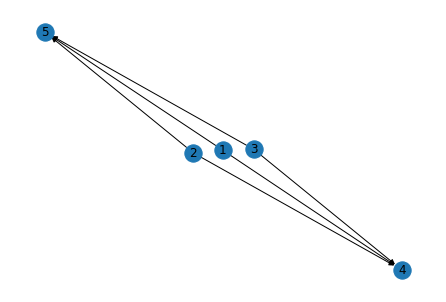

In [ ]:
G = nx.DiGraph()
G.add_nodes_from([1,2,3,4,5])
G.add_edges_from([(1,4), (1,5), (2,4), (2,5), (3,4), (3,5)])
nx.set_node_attributes(G, {1:'LA', 2:'Detroit', 3:'New Orleans', 4:'Denver', 5:'Miami'}, 'nombre')
nx.set_node_attributes(G, {1:'O', 2:'O', 3:'O', 4:'D', 5:'D'}, 'tipo')
nx.set_node_attributes(G, {1:1000, 2:1500, 3:1200, 4:2300, 5:1400}, 'valor')
nx.set_edge_attributes(G, {(1,4):1000, (1,5):2690, (2,4):1250, (2,5):1350, (3,4):1275, (3,5):850}, 'costos')

nx.draw(G, with_labels = True)

{(1, 4): Text(0.12851091350244254, -0.9119948509864327, '1000.0'),
 (2, 4): Text(0.21059137268966388, -0.42848688429527965, '1300.0'),
 (2, 5): Text(0.0394960617376036, 0.5238928147754671, '200.0'),
 (3, 5): Text(-0.192267505877186, 0.8881020362109657, '1200.0')}

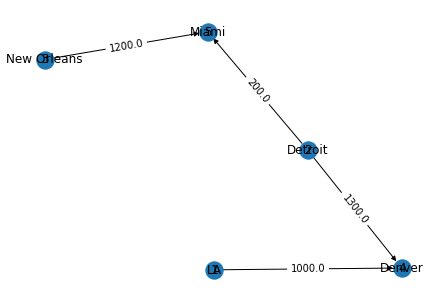

In [ ]:
G_resultado = transporte_optimo(G)
pos = nx.spring_layout(G_resultado)
nx.draw(G_resultado, pos, with_labels=True)
node_labels = nx.get_node_attributes(G_resultado,'nombre')
nx.draw_networkx_labels(G_resultado, pos, labels = node_labels)
edge_labels = nx.get_edge_attributes(G_resultado, 'transferencia')
nx.draw_networkx_edge_labels(G_resultado, pos, edge_labels = edge_labels)


## 3: Example with random starting graph

In [ ]:
# Function to assign random suppliers and demanders within graph 
def asignador_tipo(i,umbral):
    tipo = 'D'
    if i<umbral:
        tipo = 'O'
    return tipo

#Function to create all edges between suppliers and demanders
def asignador_enlaces(i,j,umbral):
    asignado = False
    if (i<umbral) and (j>=umbral):
        asignado = True 
    return asignado

# Function to assign random costs to edges
def asignador_costos(a,b):
    asignado = random.randint(a,b)
    return asignado

In [ ]:
# Initial graph:
# Basics
N = 10 # Number of agents
umbral = (N//4)*3 # Threshold separating the ids of suppliers (<umbral) and demanders (>=umbral).
a = 20 # Lower limit of cost
b = 80 # Upper limit of cost
alpha = 1 # \alpha\in (0,1]  Approximate maximum Demand/Supply Ratio 

# Creating the graph
G = nx.DiGraph()
G.add_nodes_from(range(N))
G.add_edges_from([(i,j) for i,j in it.product(G.nodes,G.nodes) if asignador_enlaces(i,j,umbral)])

# Assigning S/D attribute to each node
dict_tipo = {i:asignador_tipo(i,umbral) for i in G.nodes}
nx.set_node_attributes(G,dict_tipo,'tipo')

# Assigning cost to each edge
dict_costos = {enlace:asignador_costos(a,b) for enlace in G.edges}
nx.set_edge_attributes(G,dict_costos,'costos')

# Assining value to each node
A = np.floor(a*(N/umbral))
B = np.floor(b*(N/umbral))
dict_D = {i:asignador_costos(A,B) for i in G.nodes if G.nodes[i]['tipo']=='D'}
dict_O = {i:asignador_costos(a,b) for i in G.nodes if G.nodes[i]['tipo']=='O'}
c = 0
oferta = sum(dict_O.values())
for nodo in dict_D:
    if c+dict_D[nodo]>alpha*oferta:
        dict_D[nodo] = 0
    c += dict_D[nodo]
dict_valores = {}

for diccionario in [dict_O,dict_D]:
    for nodo in diccionario:
        dict_valores[nodo] = diccionario[nodo]

nx.set_node_attributes(G,dict_valores,'valor')

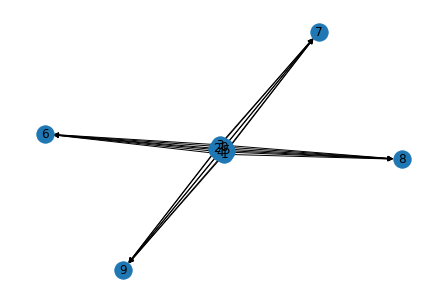

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True)

{(0, 7): Text(-0.22975612403451645, 0.460377245162387, '58.0'),
 (0, 8): Text(0.29862912926879387, 0.590018286281863, '21.0'),
 (1, 8): Text(0.5135593045712836, 0.520197006057227, '23.0'),
 (2, 8): Text(0.5709438181255666, 0.5798672643600689, '58.0'),
 (3, 8): Text(0.2671485967109673, 0.37175491362593294, '20.0'),
 (3, 9): Text(-0.32608851222118085, -0.18868119996472324, '28.0'),
 (4, 6): Text(-0.02721538648820608, -0.8641918564191557, '63.0'),
 (4, 9): Text(-0.4228382203399448, -0.5982888953855576, '2.0'),
 (5, 9): Text(-0.5310909568124775, -0.4153264235379518, '69.0')}

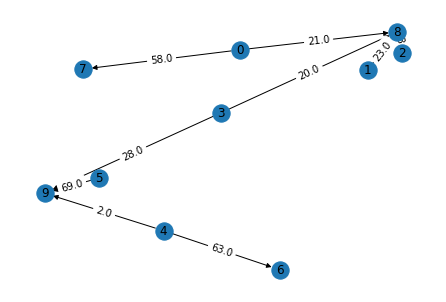

In [ ]:
G_resultado = transporte_optimo(G)
pos = nx.spring_layout(G_resultado)
nx.draw(G_resultado, pos, with_labels=True)
node_labels = nx.get_node_attributes(G_resultado,'nombre')
nx.draw_networkx_labels(G_resultado, pos, labels = node_labels)
edge_labels = nx.get_edge_attributes(G_resultado, 'transferencia')
nx.draw_networkx_edge_labels(G_resultado, pos, edge_labels = edge_labels)